In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import random
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
  for gpu in gpus:
    try:
      print("Enabling GPU: ", gpu)
      tf.config.experimental.set_visible_devices(gpu, 'GPU')
      tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
      print(e)

Enabling GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
val_size = 0.3
rand_seed = random.randint(0, 2**32 - 1)
img_dim = 96
batch_size = 8
num_color_channels = 3

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  os.path.join("data", "training"),
  validation_split = val_size,
  subset = "training",
  seed = rand_seed,
  image_size = (img_dim, img_dim),
  batch_size = batch_size,
  shuffle = True)

val_ds = tf.keras.utils.image_dataset_from_directory(
  os.path.join("data", "training"),
  validation_split = val_size,
  subset = "validation",
  seed = rand_seed,
  image_size = (img_dim, img_dim),
  batch_size = batch_size,
  shuffle = True)

num_classes = len(train_ds.class_names)

Found 1970 files belonging to 2 classes.
Using 1379 files for training.
Found 1970 files belonging to 2 classes.
Using 591 files for validation.


2025-02-09 23:55:29.007730: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-02-09 23:55:29.007755: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-02-09 23:55:29.007764: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
I0000 00:00:1739163329.007783 53748458 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1739163329.007809 53748458 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
image_input = keras.Input(shape = (img_dim, img_dim, num_color_channels))
x = keras.layers.Rescaling(1.0 / 255)(image_input)
x = keras.layers.Conv2D(128, kernel_size = (3, 3), activation = 'relu')(x)
x = keras.layers.MaxPooling2D(pool_size = (2, 2))(x)
x = keras.layers.Conv2D(256, kernel_size = (3, 3), activation = 'relu')(x)
x = keras.layers.MaxPooling2D(pool_size = (2, 2))(x)
feature_output = keras.layers.Dropout(0.01)(x)

x = keras.layers.Flatten()(feature_output)
x = keras.layers.Dense(2048, activation = 'relu')(x)
classification_output = keras.layers.Dense(num_classes)(x)

model = keras.models.Model(image_input, classification_output)

In [6]:
opt = keras.optimizers.Adagrad(learning_rate = 0.01)
model.compile(optimizer = opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 94, 94, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 123904)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │   253,757,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 254,060,290 (969.16 MB)

 Trainable params: 254,060,290 (969.16 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
class_names = train_ds.class_names
AUTOTUNE = tf.data.AUTOTUNE
epochs = 16

In [8]:
hist = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs, 
  callbacks = []
)

Epoch 1/16


2025-02-09 23:55:29.419843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


173/173 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.6779 - loss: 0.7082 - val_accuracy: 0.8139 - val_loss: 0.3649
Epoch 2/16
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.9287 - loss: 0.1791 - val_accuracy: 0.9712 - val_loss: 0.0973
Epoch 3/16
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9660 - loss: 0.0911 - val_accuracy: 0.9662 - val_loss: 0.1055
Epoch 4/16
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9830 - loss: 0.0467 - val_accuracy: 0.9780 - val_loss: 0.0694
Epoch 5/16
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9881 - loss: 0.0350 - val_accuracy: 0.9729 - val_loss: 0.1110
Epoch 6/16
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9915 - loss: 0.0293 - val_accuracy: 0.9865 - val_loss: 0.0568
Epoch 7/16
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9957 - loss: 0.0190 - val_accuracy: 0.9797 - val_loss: 0.0685
Epoch 8/16
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.9873 - loss: 0.0361 - val_accurac

In [9]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  os.path.join("data", "test"),
  shuffle = False,
  image_size = (img_dim, img_dim)
)

Found 30 files belonging to 2 classes.


In [10]:
model.evaluate(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 0.0344


[0.03435651957988739, 1.0]

In [11]:
predictions = np.argmax(model.predict(test_ds), axis = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


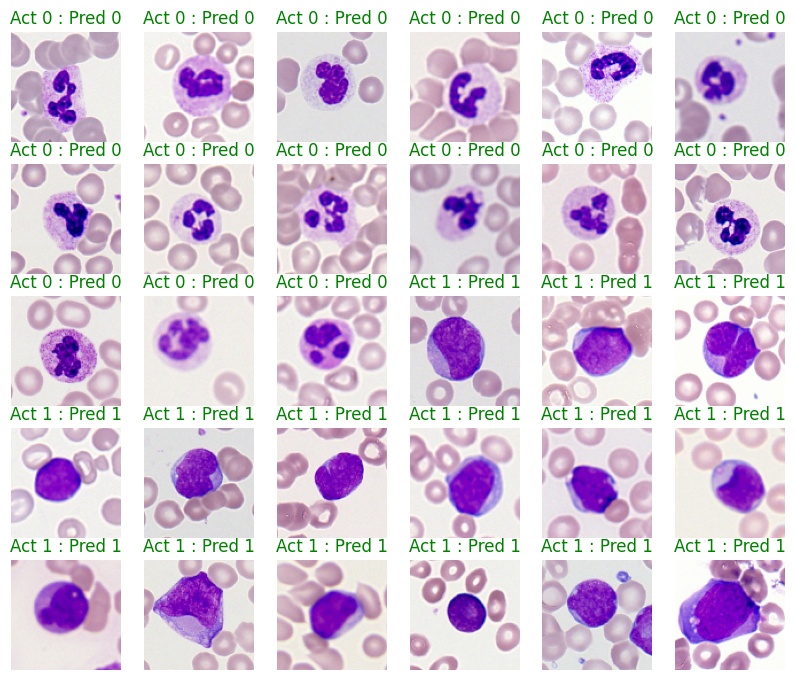

In [15]:
images, labels = next(iter(test_ds.take(1)))

plt.figure(figsize=(10, 10))

for i in range(len(images)):
    s = plt.subplot(6, 6, i +  1)
    plt.imshow(images[i].numpy().astype('uint8'))
    color = 'green' if labels[i].numpy() == predictions[i] else 'red'
    plt.title(f"Act {labels[i].numpy()} : Pred {predictions[i]}", color = color)
    s.axis('off')